# DATALOADER

In [2]:
import os
#os.system("export CUDA_VISIBLE_DEVICES='0'")
import numpy as np
import keras
import os
import pandas as pd
import seaborn as sns
import scipy as sp
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from keras import backend as K

from keras.utils import to_categorical
import glob
from keras.models import Model
from keras.engine import Layer, InputSpec
from keras.layers.normalization import BatchNormalization
from keras import initializers
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
print(os.getcwd())
sns.set()
np.set_printoptions(threshold=np.nan,precision=3,suppress=True)

/home/adrien/projet


# LOADING RESNET50, INCEPTION_V3, and NASNETMODEL

In [3]:
from resnet152 import * 

In [4]:
print("Loading ResNet50")
modelresnet50 = keras.applications.resnet50.ResNet50(weights='imagenet')
print("Loading Inception_V3")
modeliv3 = keras.applications.inception_v3.InceptionV3(weights='imagenet')
print("Loading NasNet")
modelnasnet = keras.applications.nasnet.NASNetMobile(weights='imagenet')
print("Loading ResNet_152")
model152 = resnet152_model('resnet152_weights_tf.h5')


Loading ResNet50
Loading Inception_V3
Loading NasNet
Loading ResNet_152


In [13]:
modelresnet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

# LOADING IMAGENET FROM FILE AND CREATION OF FEATURES VECTORS 
We use 25 categories of ImageNet (unused during the training of resnet, nasnet and iv3) and we select a subset of "num_samples" images per classes. 

In [11]:
categories = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24"]
num_classes = len(categories)
num_samples = 250

In [18]:
def loaddescriptors():
    iv3vec = np.array(())
    resnet50vec = np.array(())
    nasnetvec = np.array(())
    resnet152 = np.array(())

    descriptor ={
    "inceptionv3" :iv3vec, 
    "resnet50":resnet50vec , 
    "nasnet": nasnetvec,
    "resnet152": resnet152
    }

    for key in descriptor:
        print(key)
        archive = np.load(key+'.npz')
        descriptor[key] = archive['arr_0']

    archive = np.load("label.npz")
    label = archive['arr_0']


    print(descriptor["resnet152"].shape)
    print(descriptor["inceptionv3"].shape)
    print(descriptor["nasnet"].shape)
    print(descriptor["resnet50"].shape)
    print(label.shape)
    
    return descriptor,label


In [16]:
def returnimage(path,size):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return np.expand_dims(cv2.resize(gray,(size,size)), axis=0)

def generateonefv(image,layername,intermediate_layer_model):
    return intermediate_layer_model.predict(image)


def batchfv(model, matrix,layername):
    name = model.name
    
    if len(model.get_layer(layername).output_shape) > 3:
        features = np.zeros((0,model.get_layer(layername).output_shape[1],model.get_layer(layername).output_shape[1],model.get_layer(layername).output_shape[3]))
    
    if len(model.get_layer(layername).output_shape) < 3:
        features = np.zeros((0,model.get_layer(layername).output_shape[1]))
    
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layername).output)

    for i in range(matrix.shape[0]):
        a = generateonefv(np.expand_dims(matrix[i],axis=0),layername,intermediate_layer_model)
        features = np.concatenate((a, features), axis=0)
      
    return features
    

def generateallfv(categories, num_samples):
        descriptors ={
        "inceptionv3" :np.array(()), 
        "resnet50":np.array(()), 
        "nasnet":np.array(()) ,
        "resnet152":np.array(()) 
        }
        Label = []
        res = np.zeros((0,224,224,3))
        vecnas = np.zeros((0,1056))
        veciv3 = np.zeros((0,2048))
        vecres50 = np.zeros((0,2048))
        vecres152 = np.zeros((0,2048))
        
        
        for category in tqdm(categories): #For each category
            listimage = glob.glob('./data/images_classes/'+category+'/*.JPEG')  #list images 
            w =0
            for images in listimage: # for each images 
                if w == num_samples:
                    break
                Label.append(category)
                
                m = returnimage(images,224) #return a resized image as 1,224,224,3 np array
                res = np.concatenate((res, m), axis=0)
                w+=1
            vecnas = np.concatenate((vecnas,batchfv(modelnasnet, res/255,"global_average_pooling2d_1")),axis=0)
            veciv3 = np.concatenate((veciv3,batchfv(modeliv3, res/255,"avg_pool")),axis=0)
            vecres50 = np.concatenate((vecres50,batchfv(modelresnet50, res,"avg_pool")),axis=0)
            vecres152 = np.concatenate((vecres152,batchfv(model152, res,"flatten_1")),axis=0)
            res = np.zeros((0,224,224,3))
            
        
        for key,vec in zip(descriptors,[veciv3,vecres50,vecnas,vecres152]):
            descriptors[key] = vec
            
        np.savez('label', Label)
        Label = np.asarray(Label)
        np.savez('nasnet', vecnas)
        np.savez('resnet50', vecres50)
        np.savez('inceptionv3', veciv3)
        np.savez('resnet152', vecres152)
            
        return descriptors, Label
    


    

[[[[ 41  45  21]
   [ 80  93  59]
   [ 52  78  43]
   [ 42  55  22]
   [ 78  87  49]
   [ 86 103  54]
   [ 89  96  53]
   [ 31  61  19]
   [ 54  74  31]
   [ 41  57  13]
   [ 58  84  37]
   [ 60  84  38]
   [ 53  74  27]
   [ 54  77  38]
   [ 69  97  48]
   [ 69  92  43]
   [ 47  77  28]
   [ 41  67  23]
   [ 82  99  64]
   [ 69  95  53]
   [ 54  76  31]
   [ 69  90  39]
   [ 77  99  48]
   [ 79 101  52]
   [ 92 120  72]
   [ 33  72  31]
   [ 63  85  40]
   [ 61  88  43]
   [ 73 101  59]
   [ 98 122  77]
   [ 65  86  43]
   [ 36  66  28]
   [ 81  98  62]
   [ 76 103  58]
   [ 81 108  61]
   [ 84 109  62]
   [ 96 120  58]
   [ 87 105  56]
   [ 88 116  63]
   [ 61  91  47]
   [ 67  89  43]
   [ 31  53  24]
   [ 56  76  46]
   [100 116  76]
   [ 77  97  52]
   [ 37  62  21]
   [ 44  70  29]
   [ 72  97  52]
   [ 64  88  47]
   [ 68  86  49]
   [ 78 106  57]
   [ 57  79  45]
   [ 65  86  56]
   [ 64  89  49]
   [ 43  71  25]
   [ 74  94  50]
   [ 52  80  36]
   [ 56  79  38]
   [ 89 107  7

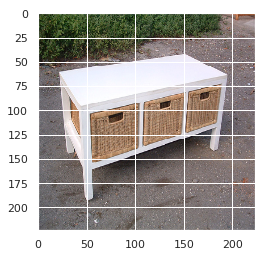

In [52]:
m = returnimage('./data/images_classes/0/n03233905_148.JPEG',224)
print(m)
plt.imshow(np.squeeze(m,axis=0))
plt.show()

# LOAD STORED FEATURES VECTORS

In [17]:
descriptor, label = generateallfv(categories, num_samples)


100%|██████████| 25/25 [09:03<00:00, 22.08s/it]


# MATRIX dist

In [ ]:
def computeinterscore(A,B):
    score = sp.spatial.distance.cdist(A,B,metric='cosine').sum()/sp.spatial.distance.cdist(A,B).size
    return score


def distancematrix(vec):
    i_index=0
    j_index=0
    result = []
    for i in categories:
        i_index = categories.index(i)*num_samples
        intra = computeinterscore(vec[i_index:(i_index+num_samples)],vec[i_index:(i_index+num_samples)])
        for j in categories:
            j_index = categories.index(j)*num_samples
            inter = computeinterscore(vec[i_index:(i_index+num_samples)],vec[j_index:(j_index+num_samples)])
            result.append(intra/inter)
    result = np.matrix(result).reshape((num_classes,num_classes)) #reshape as matrix
    return result
    
    
def plotdistancematrix(descriptors):
    j = 0
    w=0
    fig1 = plt.figure()
    fig1.suptitle('Distance Matrix with cosine distance', fontsize=20)
    fig1.set_size_inches(15,10)
    for elements,name in zip([iv3vec,nasvec,resnetvec],["Inception_V3","Nasnet","ResNet"]):
        axe = fig1.add_subplot(2,2,j+1)
        axe.set_xlabel('Number of samples')
        axe.set_ylabel('Accuracy %')
        print(elements.shape)
        value = distancematrix(elements)
        print(name)
        ax = sns.heatmap(value,label="HELLO")
        ax.xaxis.set_ticks_position('top')
        plt.title(name,size='13',pad=30)
        j += 1 



(6250, 2048)
Inception_V3
(6250, 1056)
Nasnet
(6250, 2048)
ResNet


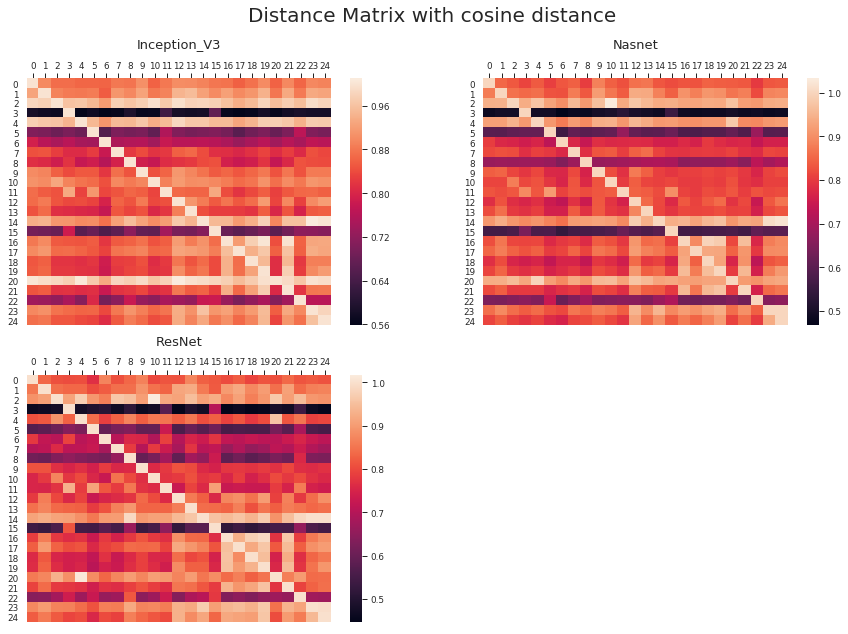

In [187]:
plotdistancematrix(featuresveciv3,featuresvecnas,featuresvecresnet)

# TESTING QUALITY

In [11]:

def stress(features, L,  n_tests):
    scores = np.zeros((4))
    for i in range(n_tests):
        classifiers = [KNeighborsClassifier(metric='cosine'), SVC(), RandomForestClassifier(), MLPClassifier(hidden_layer_sizes=(500,500,))]
        X_train, X_test, y_train, y_test = model_selection.train_test_split(features, L, test_size=.25)
        y_train = y_train.ravel()
        y_test = y_test.ravel()
        for i in range(len(classifiers)):
            clf = classifiers[i]
            clf.fit(X_train,y_train)
            scores[i] += clf.score(X_test,y_test)
    return scores/n_tests


def selectsubset(featuresvec, size, L):
    i=0
    index= np.zeros((1,size))
    for values in range(num_classes):
        i += num_samples 
        a = np.random.randint(i-num_samples,i ,size=size)
        index = np.append(index,a)
    sampeled = featuresvec[index[size:].astype(int)]
    Lab = L[index[size:].astype(int)]
    return sampeled, Lab

def estimatefvquality(descriptors, L, numsubtest):
    sns.set_palette(sns.color_palette("hls", 4))
    paper_rc = {'lines.linewidth': 3}                  
    sns.set_context("paper", rc = paper_rc) 
    i=0
    result ={
    "inceptionv3" :np.zeros((0,4)), 
    "resnet50":np.zeros((0,4)), 
    "nasnet":np.zeros((0,4)),
    "resnet152":np.zeros((0,4))
    }
    
   
    xticks = [i for i in range(2,num_samples,5)]
    for xtick in tqdm(xticks):
        for j,key in enumerate(descriptors):
            subvec, sublabel = selectsubset(descriptors[key],xtick,L)
            result[key] = np.concatenate((np.expand_dims(stress(subvec, sublabel,numsubtest),axis=0),result[key]),axis=0)

            
            
    fig1 = plt.figure()
    fig1.suptitle('Transfer performance using resnet50 nasnet and iv3 as descriptors', fontsize=16)
    fig1.set_size_inches(15,10)        
    
    for i,algo in enumerate(["KNN","SVM","RF","MLP"]):
        df = pd.DataFrame({'accuracy':[], 'network':[]})
        axe = fig1.add_subplot(2,2,i+1)
        axe.set_title(algo)
        axe.set_xlabel('Number of samples')
        axe.set_ylabel('Accuracy %')
        for key in result:
            df["accuracy"] = pd.Series(result[key][:,i][::-1],index=xticks)
            sns.lineplot(y=df["accuracy"].values,x=df.index.values,label=key)


100%|██████████| 50/50 [13:20:22<00:00, 2090.00s/it]  


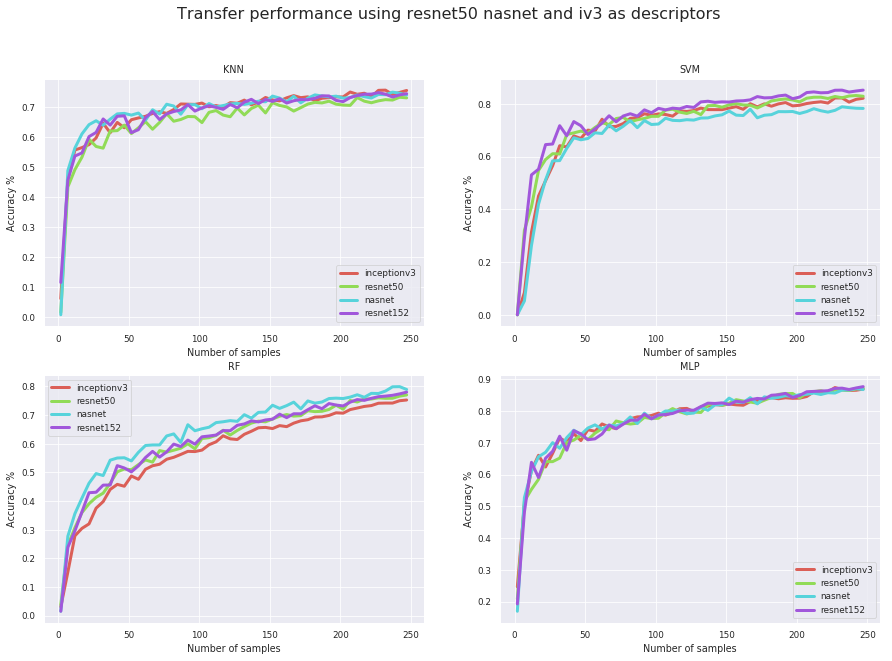

In [12]:
estimatefvquality(descriptor, label,10)

# CRAFTING SELECTED FEATURES

In [20]:


def getavgpool(b2):
    r = []
    for w in range(b2.shape[0]):
        for i in range(b2.shape[3]):            
            z = b2[w,:,:,i]
            r.append(np.sum(z)/(b2.shape[2]*b2.shape[1]))
    w = np.array(r)
    w = w.reshape(b2.shape[0],b2.shape[3])
    return w


def craftfeatures(layerlist, categories, num_samples,model):
    L = []
    shape = 0
    
    for element in layerlist:
        if len(modelresnet50.get_layer(element).output_shape) > 3:
            shape += modelresnet50.get_layer(element).output_shape[3]
        else: 
            shape += modelresnet50.get_layer(element).output_shape[1]
            

    craftvec=np.zeros((0,shape))
    imagematrix = np.zeros((0,224,224,3))
    vecres50 = np.zeros((0,2048))
    
    for category in categories: #For each category
        listimage = glob.glob('./data/images_classes/'+category+'/*.JPEG')  #list images 
        w =0
        for images in listimage: # for each images 
            if w == num_samples:
                break
            L.append(category)
            m = returnimage(images,224) #return a resized image as 1,224,224,3 np array
            imagematrix = np.concatenate((imagematrix, m), axis=0)
            w+=1
        inter = np.zeros((imagematrix.shape[0],0))
        
        for layer in layerlist:
            test = batchfv(modelresnet50,imagematrix,layer) 
            
            if len(test.shape) > 3:
                inter = np.concatenate((inter, getavgpool(test)),axis=1)
                       
            if len(test.shape) < 3: 
                inter = np.concatenate((inter,test),axis=1)
  
        craftvec= np.concatenate((craftvec,inter),axis=0)
        inter = np.zeros((imagematrix.shape[0],0)) 
        imagematrix = np.zeros((0,224,224,3))
    L = np.array(L)
    name = ''.join(layerlist)
    #np.savez(name, craftvec)
    return craftvec, L




# TEST CRAFTED 

In [24]:
def testcrafted(biglist):
    ResultsDf = pd.DataFrame()
    for element in biglist:
        print("For layers", ''.join(element))
        print(element)
        vec ,L = craftfeatures(element,categories,num_samples,modelresnet50)
        name = ''.join(element)
        ResultsDf[name] = pd.Series(knn_bestk(vec,L),index=["cosine"])
    print("FINISH")
    return ResultsDf


def knn_bestk(vec,label):
    result = 0
    bestresult = 0 
    bestk = 0
    for j in range(2,15):
        for i in range(25):
            knn = KNeighborsClassifier(j, metric='cosine')
            xtrain, xtest, ytrain, ytest = model_selection.train_test_split(vec, label, test_size=.25)
            ytrain = ytrain.ravel()
            ytest = ytest.ravel()
            result += knn.fit(xtrain, ytrain).score(xtest, ytest)
        result = result/25
        print(result)
        if result >= bestresult:
            bestresult = result
            bestk = j
        result = 0
    return bestresult


In [83]:
biglist = [["activation_43"]]
b= testcrafted(biglist)

For layers activation_43
['activation_43']
estimated shape 2048
Loading files for categories : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']


KeyboardInterrupt: 

          x  taille   time      y                  group
0  25636712    2048  12.13  0.723               ResNet50
1  60495656    2048  27.25  0.740              ResNet152
2   5326712    1056  15.71  0.696                 NasNet
3  23851784    2048  15.14  0.715                    Iv3
4  65822372    3104  42.90  0.756       ResNet152+NasNet
5  25636712    3072  12.13  0.710  ResNet50+2Activations
6  25636712    2048  12.13  0.690   ResNet50 other layer
(7, 5)


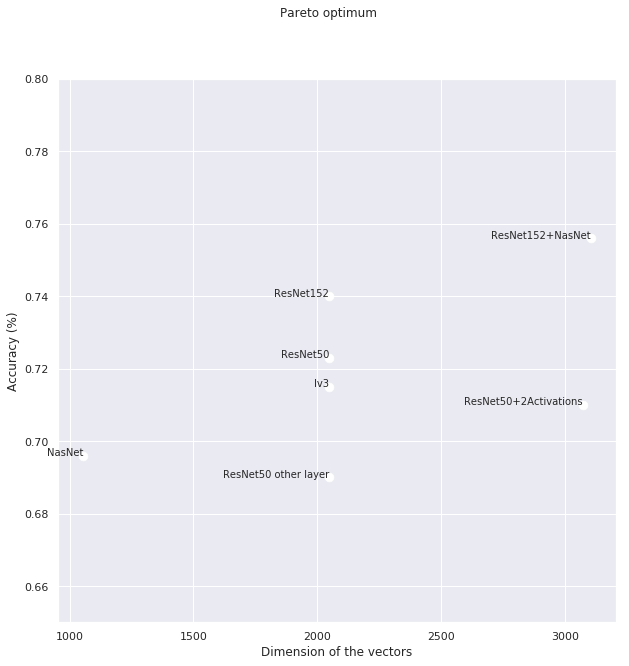

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle("Pareto optimum")
df = pd.DataFrame({
'x': [25636712, 60495656, 5326712, 23851784, 65822372,25636712,25636712],
'taille': [2048,2048,1056,2048,3104,3072,2048],
'time' : [12.13,27.25,15.71,15.14,42.9,12.13,12.13],
'y': [0.723, 0.74, 0.696, 0.715, 0.756,0.71,0.69],
'group': ['ResNet50','ResNet152','NasNet','Iv3','ResNet152+NasNet','ResNet50+2Activations','ResNet50 other layer']
})

print(df)
p1=sns.scatterplot(data=df, x="taille", y="y",marker="o",s=75,color='#ffffff')
p1.set_ylim(0.65, 0.8)
#p1.set_xlim(0, 45)
p1.set_xlabel("Dimension of the vectors")
p1.set_ylabel("Accuracy (%)")
# add text annotation
print(df.shape)
for line in range(0,df.shape[0]):
     p1.text(df.taille[line]+0.2, df.y[line], df.group[line], horizontalalignment='right', size='medium',rotation=0)


In [25]:
knn_bestk(descriptor["resnet50"],label)

0.6693538067818298
0.6891618682021755
0.6953039027511196
0.6968394113883556
0.6936404350607804
0.6973000639795265
0.6984516954574534
0.6969161868202177
0.6956621880998081
0.6936404350607807
0.6980678182981447
0.6937939859245043
0.6971976967370442


0.6984516954574534

In [21]:
desc,label = loaddescriptors()
import random
test = a['resnet50']
np.var(test)

def generate_sliced(n_estim, estimateur,data,label,split):
    classifier = [] 
   
    
    xtrain, xtest, y_train, y_test = model_selection.train_test_split(data, label, test_size=.25,
                                                                      stratify=label,random_state=42)
    
    vincent = np.zeros((xtrain.shape[0],xtrain.shape[1]//n_estim,0))
    vincent2 = np.zeros((xtest.shape[0],xtest.shape[1]//n_estim,0))
    result = np.zeros((0,len(y_test)))
    sub_x_test = np.zeros((0,xtrain.shape[1]//n_estim))
    sub_x_train = np.zeros((0,xtest.shape[1]//n_estim))

    if split == "next":
        index = linearsplit(xtrain,n_estim)
    elif split == "random": 
        index = datasplit(xtrain,n_estim) # renvoi liste d'index unique
    elif split == "variance": 
        index = variancesplit(xtrain,n_estim) # renvoi liste d'index unique    

    for i in range(n_estim):
        for value in range(xtrain.shape[0]):
            sub_x_train = np.concatenate((sub_x_train,xtrain[value][index[i]].reshape(1,-1)),axis=0)
        sub_x_train = np.expand_dims(sub_x_train, axis=2)
        vincent = np.concatenate((vincent,sub_x_train),axis=2)

        for value in range(xtest.shape[0]):   
            sub_x_test = np.concatenate((sub_x_test,xtest[value][index[i]].reshape(1,-1)),axis=0)
        sub_x_test = np.expand_dims(sub_x_test, axis=2)
        vincent2 = np.concatenate((vincent2,sub_x_test),axis=2)

        classifier.append(estimateur)

        sub_x_train = np.zeros((0,xtrain.shape[1]//n_estim))
        sub_x_test = np.zeros((0,xtrain.shape[1]//n_estim))



    return vincent,vincent2,y_train, y_test

def datasplit(data,n_estim):
    index = []
    test = 0
    print(data.shape[1]//n_estim) # N VALUE PER ESTIMATOR
    a = list(range(2048))
    for estim in range(n_estim):
            b = random.sample(a, data.shape[1]//n_estim) # PICK N VALUE IN SET 
            a = [elem for elem in a if elem not in b] #NEW SET OF VALUE
            test += len(b)
            index.append(b)
    return index

train, test,y_train,y_test = generate_sliced(16,KNeighborsClassifier(10, metric='cosine'),a["resnet50"],label,"random")


inceptionv3
resnet50
nasnet
resnet152
(0, 2048)
(0, 2048)
(0, 1056)
(6250, 2048)
(6250,)
128


In [56]:
a = desc['resnet50']
x_train, x_test, y_train, y_test = model_selection.train_test_split(a, label, test_size=.25,random_state=42)
knn = KNeighborsClassifier(10, metric='cosine')
knn.fit(x_train,y_train)
knn.score(x_test,y_test)

NameError: name 'j' is not defined

In [54]:
from xgboost import XGBClassifier
a = desc['resnet50']
x_train, x_test, y_train, y_test = model_selection.train_test_split(a, label, test_size=.25,random_state=42)

model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)


NameError: name 'accuracy_score' is not defined

In [55]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.6941778630838131


In [53]:
print(np.var(train))
print(train[:,:,1].shape)
for i in range(16):

    print(np.var(train[:,:i]))

0.6379468995024277
(4687, 128)
nan
0.8185024571952882
0.9249912527628491
0.8562740940614291
0.8636467658523594
0.7983070174251949
0.8205123128749342
0.874367465481969
0.9922054840058889
0.9380236467088744
0.9136091640546445
0.8848171091155357
0.8752507192597041
0.8450691872546369
0.8383065245714826
0.8219942402218202
